In [2]:
# Imports

import os
import math

from datetime import timezone, datetime, timedelta

import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import pysal
import contextily
import xarray
import datashader

from geopy import distance
from geopy.point import Point

from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import LineString
from shapely.ops import split

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import seaborn as sns; sns.set(rc={'axes.facecolor':'white'})

import warnings
warnings.filterwarnings('ignore')

# nossos arquivos
from utils import *
from satelites import *
from graphic import *
from explore import *
from constants import *

# import locale
# locale.setlocale(locale.LC_ALL, 'pt')

In [3]:
df = read_burn_df()
df = df[(df["simp_satelite"] != "ATSR") & (df["simp_satelite"] != "TRMM")]
print('Data frame optimized with final size: {:.2f}GB'.format(df.memory_usage(deep=True).sum()/1024**3))
df.head()

Data frame optimized with final size: 2.11GB


,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,simp_satelite,sensor,regiao
0,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,PARAIBA,TRIUNFO,CAATINGA,-999,NaN,False,-6.60833,-38.58333,NaN,NOAA-12,AVHRR,NORDESTE
1,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,BAHIA,MUQUEM DO SAO FRANCISCO,CERRADO,-999,NaN,False,-12.26000,-43.65167,NaN,NOAA-12,AVHRR,NORDESTE
2,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,MATO GROSSO,RIBEIRAO CASCALHEIRA,AMAZONIA,-999,NaN,False,-12.65500,-52.05667,NaN,NOAA-12,AVHRR,CENTRO-OESTE
3,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,SAO PAULO,ALVARO DE CARVALHO,MATA ATLANTICA,-999,NaN,False,-22.12833,-49.68333,NaN,NOAA-12,AVHRR,SUDESTE
4,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,SAO PAULO,RIBEIRAO BRANCO,MATA ATLANTICA,-999,NaN,False,-24.31167,-48.68667,NaN,NOAA-12,AVHRR,SUDESTE


In [4]:
# variaveis derivadas dos dados
all_satellites = df['satelite'].value_counts().index.values
simp_satellites = df['simp_satelite'].value_counts().index.values
actual_satellites = df[(df['datahora'].dt.year == 2022)]['simp_satelite'].value_counts().loc[lambda x : x > 0].index.values

print('Original satellites size:', len(all_satellites.tolist()))
print('Simplified satellites size:', len(simp_satellites.tolist()))

Original satellites size: 32
Simplified satellites size: 22


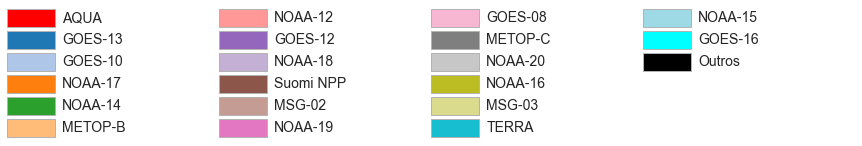

In [5]:
# Escolher cores boas paras os satélites ajuda na análise
# Ai sempre vamos usar as mesmas cores, criando gráficos 
# consistentes entre sí

# import random

# random.seed(43)

# simp_satellites_rand = simp_satellites.tolist()
# random.shuffle(simp_satellites_rand)
# cmap = plt.cm.get_cmap('tab20', len(simp_satellites_rand))
# satellites_colors = {}
# for (i, satelite) in enumerate(simp_satellites_rand):
#     satellites_colors[satelite] = cmap(i)

# satellites_colors[simp_satellites_rand[0]] = (1.0, 0.0, 0.0, 1.0)
# satellites_colors[simp_satellites_rand[-1]] = (0.0, 1.0, 1.0, 1.0)

fig = plot_colortable(satellites_colors)
fig.savefig(os.path.join(image_folder, 'cores_satelites.pdf'), bbox_inches="tight")

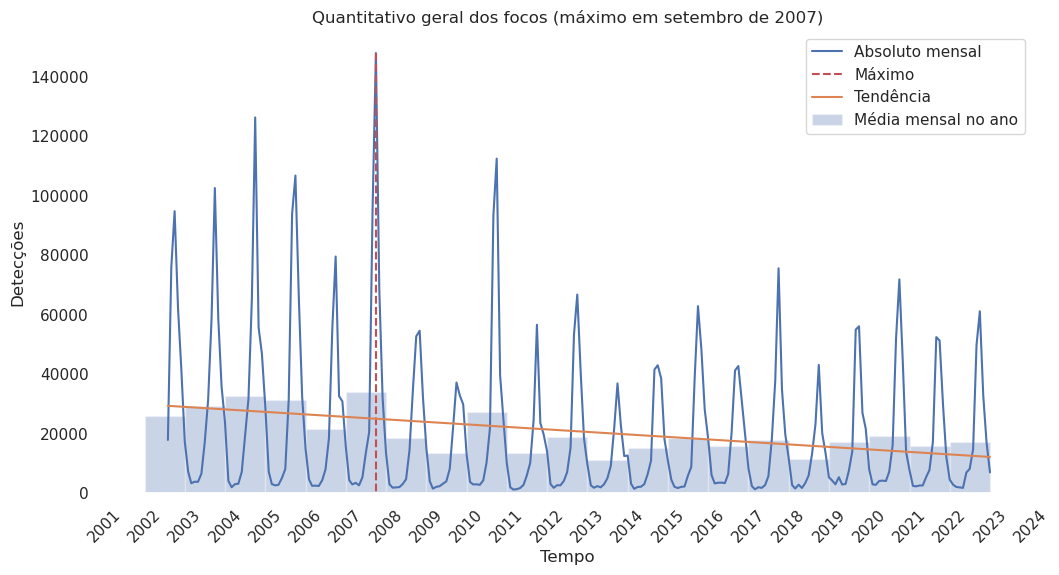

In [5]:
# analise quantitativa dos dados com relacao a flag risco de fogo
reference_df = df[(df.satelite == 'AQUA_M-T')]

date_sem_risco_counts = reference_df.groupby([reference_df['datahora'].dt.date])['datahora'].count()

daily_df = date_sem_risco_counts.fillna(0).astype('int')
daily_df.index = pd.to_datetime(daily_df.index)
monthly_df = daily_df.resample('M').sum()
yearly_df = daily_df.resample('Y').sum() / 12
maxX: pd.Timestamp = monthly_df.idxmax()
maxY = monthly_df.max()

fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.bar(yearly_df.index - pd.Timedelta(days=365), yearly_df.values, width=365, label='Média mensal no ano', alpha=0.3, align='edge')

monthly_df = monthly_df.to_frame('value').reset_index()
ax.plot_date(monthly_df['datahora'], monthly_df['value'], label='Absoluto mensal', linestyle='-', marker='')

ax.vlines(maxX, maxY, 0, color='r', linestyles='--', label='Máximo')

# trend line
z = np.polyfit(x=monthly_df['datahora'].astype(np.int64), y=monthly_df['value'], deg=1)
p = np.poly1d(z)
monthly_df['trendline'] = p(monthly_df['datahora'].astype(np.int64))
ax.plot(monthly_df['datahora'], monthly_df['trendline'], label='Tendência', linestyle='-', marker='')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel('Tempo')
ax.set_ylabel('Detecções')
ax.set_title('Quantitativo geral dos focos (máximo em {} de {})'.format(months_list[maxX.month-1].lower(), maxX.year))
ax.legend()

fig.savefig(os.path.join(image_folder, 'quantitativo_geral.pdf'), bbox_inches="tight")

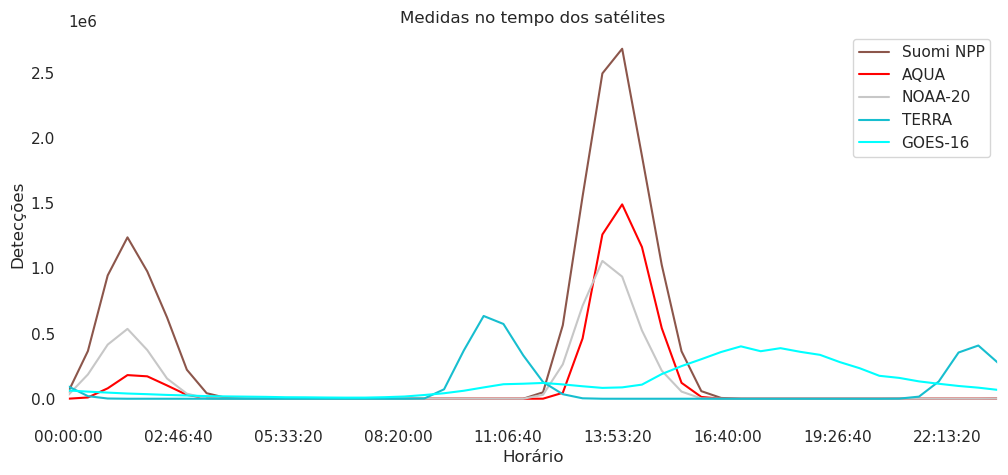

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for satelite in ['Suomi NPP', 'AQUA', 'NOAA-20', 'TERRA', 'GOES-16']:
  time_measure_dist(df, satelite, ax)

ax.set_title("Medidas no tempo dos satélites")
ax.set_ylabel('Detecções')
ax.set_xlabel('Horário')

fig.savefig(os.path.join(image_folder, 'tempo_medidas_satelites.pdf'), bbox_inches="tight")

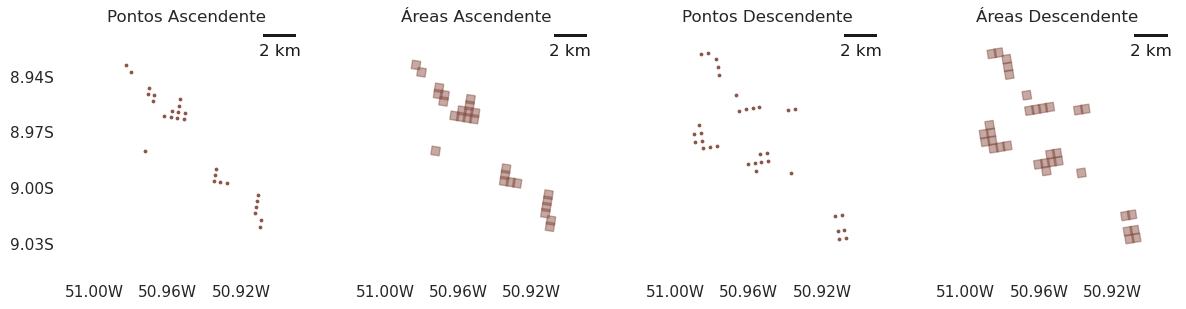

In [7]:
fig, axs = plt.subplots(1, 4, sharex= True, sharey=True, figsize=(12, 20))
fig.tight_layout()
axs = axs.flat

center_lat, center_lon, size = -8.98, -50.95, 0.13
data_temp = sub_space_by_center(df.query("'2022-09-02 00:00:00-03:00' < datahora < '2022-09-02 23:59:59-03:00' and simp_satelite == 'Suomi NPP'"), center_lat, center_lon, size)

min_lat, max_lat, min_lon, max_lon = get_bounds(center_lat, center_lon, size)

show_satelites_points(data_temp[data_temp['satelite'] == 'NPP-375D'], ax=axs[0])
axs[0].set_title('Pontos Ascendente')
configure_geografic_axes(axs[0], min_lon, max_lon, min_lat, max_lat)

show_satelites_points(data_temp[data_temp['satelite'] == 'NPP-375'], ax=axs[2])
axs[2].set_title('Pontos Descendente')
configure_geografic_axes(axs[2], min_lon, max_lon, min_lat, max_lat)

show_separated_satelittes(data_temp, center_lat, center_lon, size, axs=[axs[1], axs[3]])
axs[1].set_title('Áreas Ascendente')
axs[3].set_title('Áreas Descendente')

fig.savefig(os.path.join(image_folder, 'comparacao_pontos_e_areas.pdf'), bbox_inches="tight")

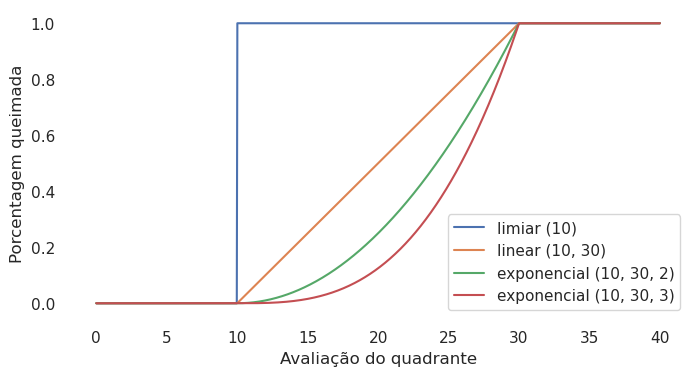

In [9]:
min_value = 0
max_value = 40
xs = np.linspace(min_value, max_value, 1000)

fig, axs = plt.subplots(1, 1, figsize=(8, 4))

f = threshold_burned_area_calc(10)
ys = [f(x, xs) for x in xs]
axs.plot(xs, ys, label='limiar (10)')

f = linear_burned_area_calc(10, 30)
ys = [f(x, xs) for x in xs]
axs.plot(xs, ys, label='linear (10, 30)')

f = polinomial_burned_area_calc(10, 30, 2)
ys = [f(x, xs) for x in xs]
axs.plot(xs, ys, label='exponencial (10, 30, 2)')

f = polinomial_burned_area_calc(10, 30, 3)
ys = [f(x, xs) for x in xs]
axs.plot(xs, ys, label='exponencial (10, 30, 3)')

axs.legend(loc='lower right')
axs.set_xlabel("Avaliação do quadrante")
axs.set_ylabel("Porcentagem queimada")

fig.savefig(os.path.join(image_folder, 'eval_func_built_in.pdf'), bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


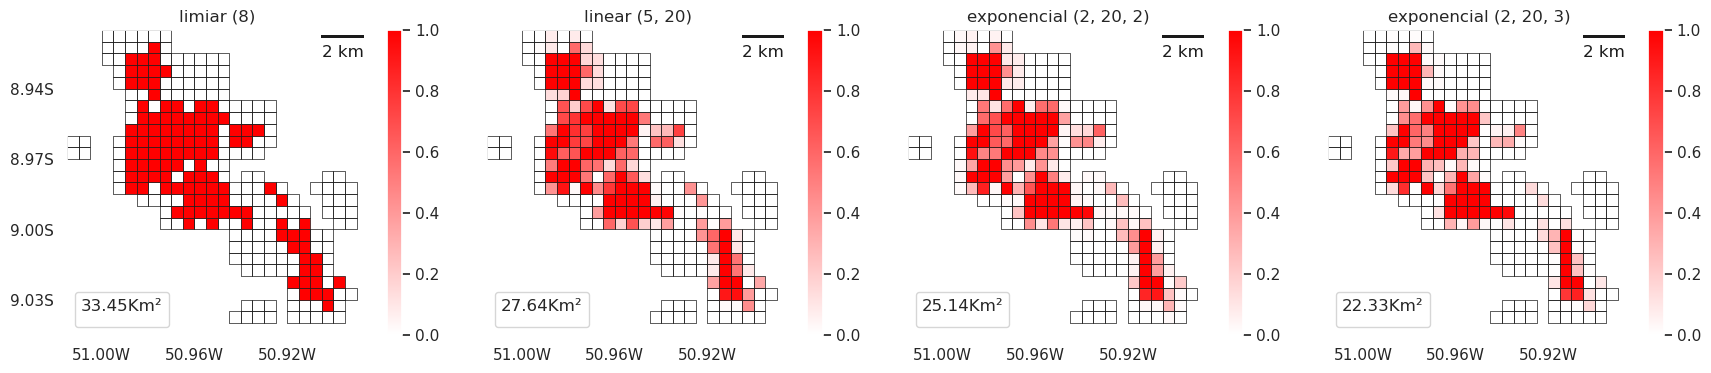

In [10]:
center_lat, center_lon, size = -8.98, -50.95, 0.13
data_temp = sub_space_by_center(df.query("'2022-09-01 00:00:00-03:00' < datahora < '2022-09-03 23:59:59-03:00'"), center_lat, center_lon, size)

width = 15
fig, axs = plt.subplots(1, 4, sharex= True, sharey=True, figsize=(width + width * 0.15, width/4))
fig.tight_layout()
axs = axs.flat

explorer = SatellitesExplore(data_temp, quadrat_width=0.005, burned_area_calc=threshold_burned_area_calc(8))
explorer.plot(center_lat=center_lat, center_lon=center_lon, size=size, only_quads_areas=True, fig=fig, axs=[axs[0]])
axs[0].set_title('limiar (8)')

explorer = SatellitesExplore(data_temp, quadrat_width=0.005, burned_area_calc=linear_burned_area_calc(5, 20))
explorer.plot(center_lat=center_lat, center_lon=center_lon, size=size, only_quads_areas=True, fig=fig, axs=[axs[1]])
axs[1].set_title('linear (5, 20)')

explorer = SatellitesExplore(data_temp, quadrat_width=0.005, burned_area_calc=polinomial_burned_area_calc(2, 20, 2))
explorer.plot(center_lat=center_lat, center_lon=center_lon, size=size, only_quads_areas=True, fig=fig, axs=[axs[2]])
axs[2].set_title('exponencial (2, 20, 2)')

explorer = SatellitesExplore(data_temp, quadrat_width=0.005, burned_area_calc=polinomial_burned_area_calc(2, 20, 3))
explorer.plot(center_lat=center_lat, center_lon=center_lon, size=size, only_quads_areas=True, fig=fig, axs=[axs[3]])
axs[3].set_title('exponencial (2, 20, 3)')

fig.savefig(os.path.join(image_folder, 'aplicacao_funcoes_built_in.pdf'), bbox_inches="tight")

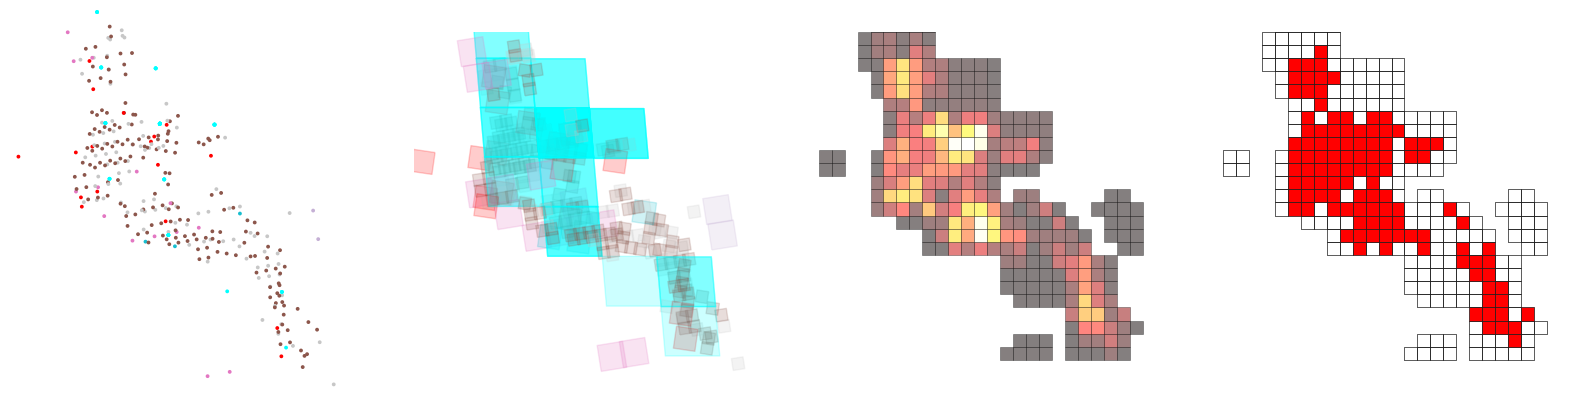

In [5]:
center_lat, center_lon, size = -8.98, -50.95, 0.13
data_temp = sub_space_by_center(df.query("'2022-09-01 00:00:00-03:00' < datahora < '2022-09-03 23:59:59-03:00'"), center_lat, center_lon, size)

explorer = SatellitesExplore(data_temp, quadrat_width=0.005, burned_area_calc=threshold_burned_area_calc(8))
fig, axs = explorer.plot(width=20, center_lat=center_lat, center_lon=center_lon, size=size, simple_plot=True)

fig.savefig(os.path.join(image_folder, 'exemplo_metodo_completo.pdf'), bbox_inches="tight")

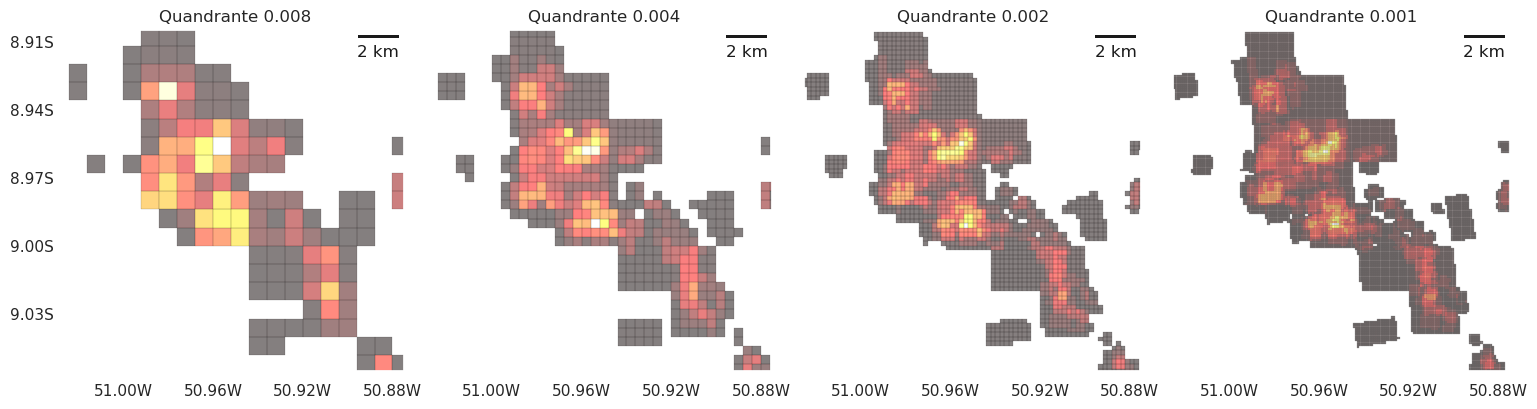

In [11]:
center_lat, center_lon, size = -8.98, -50.95, 0.15
data_temp = sub_space_by_center(df.query("'2022-09-01 00:00:00-03:00' < datahora < '2022-09-03 23:59:59-03:00'"), center_lat, center_lon, size)
min_lat, max_lat, min_lon, max_lon = get_bounds(center_lat, center_lon, size)

width_quads = [0.008, 0.004, 0.002, 0.001]
fig, axs = plt.subplots(1, len(width_quads), sharex=True, sharey=True, figsize=(15, 15/len(width_quads)))
fig.tight_layout(pad=0.0)
axs = axs.flat

for index, width in enumerate(width_quads):
        SatellitesExplore(data_temp, quadrat_width=width).show_satellites_quads_evaluated(
                with_color_bar=False, ax=axs[index], linewidth=0.2)
        axs[index].set_title('Quandrante {}'.format(width))
        configure_geografic_axes(axs[index], min_lon, max_lon, min_lat, max_lat, with_scale=True)

fig.savefig(os.path.join(image_folder, 'diferenca_entre_quadrantes.png'), bbox_inches="tight")

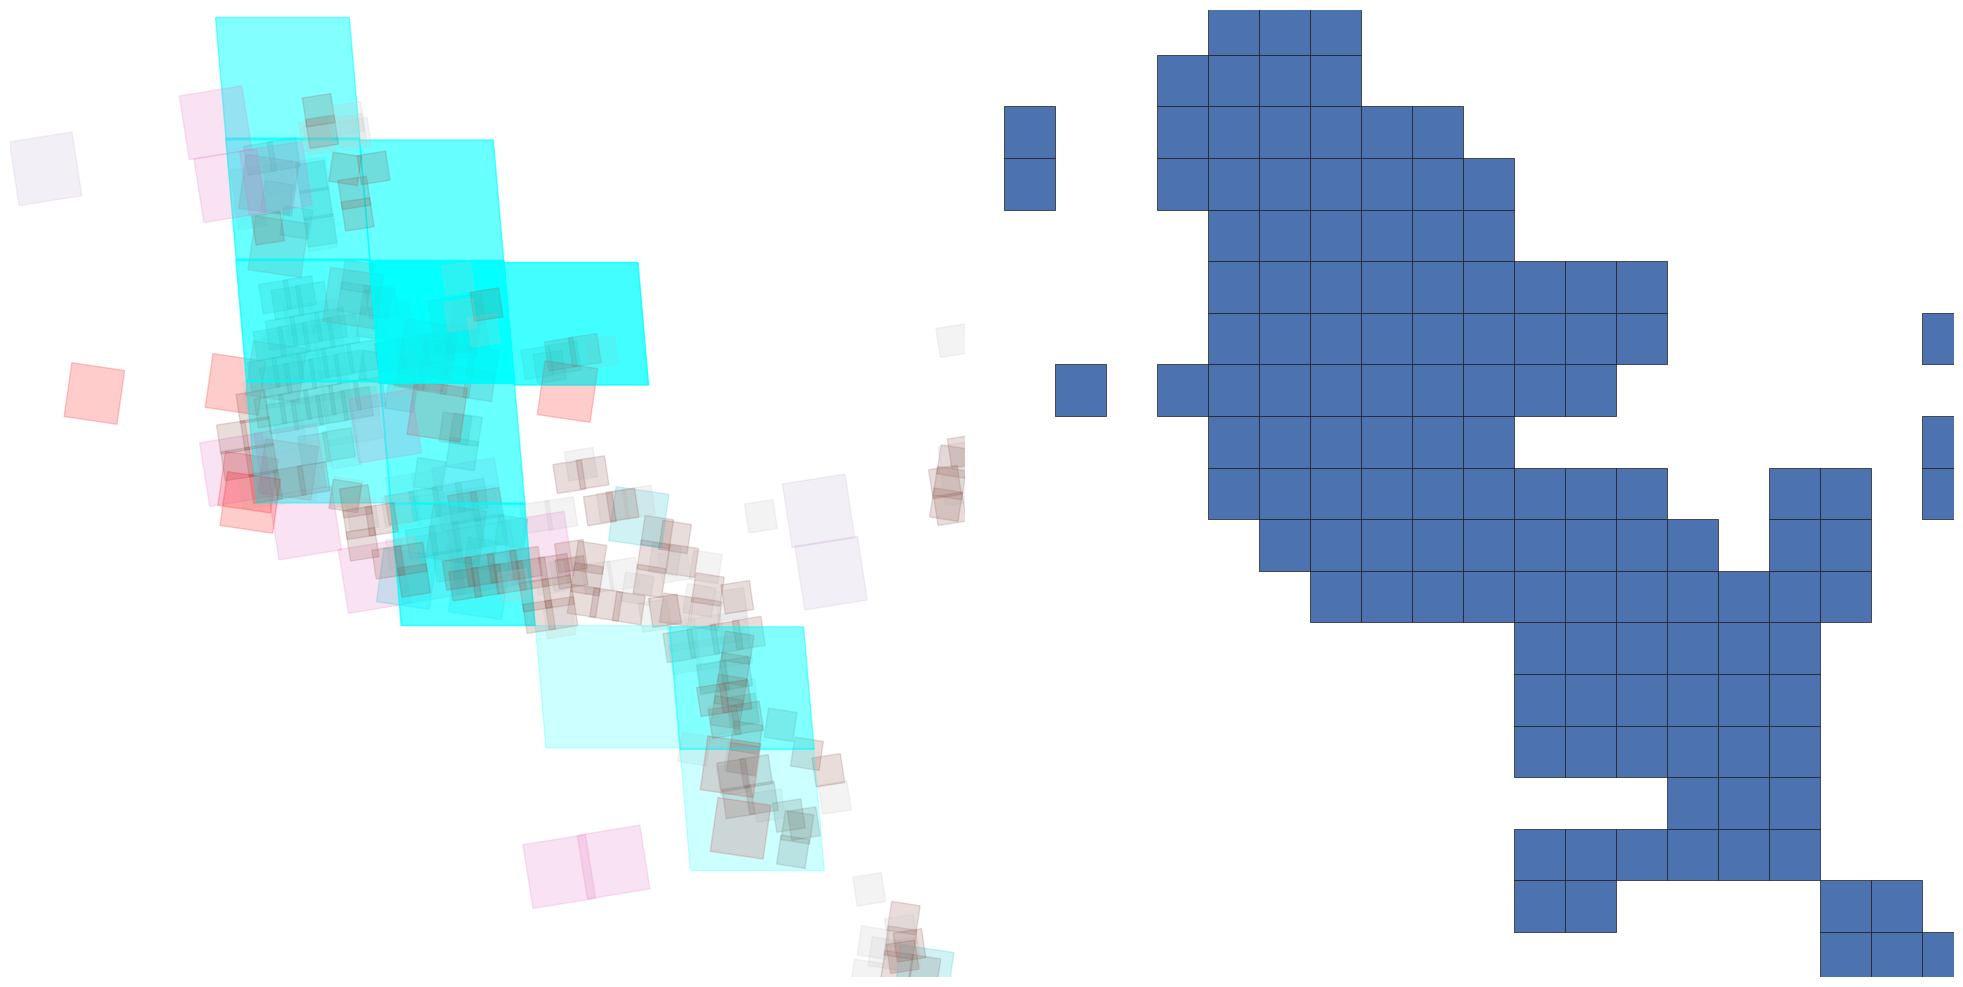

In [8]:
center_lat, center_lon, size = -8.98, -50.95, 0.15
data_temp = sub_space_by_center(df.query("'2022-09-01 00:00:00-03:00' < datahora < '2022-09-03 23:59:59-03:00'"), center_lat, center_lon, size)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 20/2))
fig.tight_layout(pad=0.0)
axs = axs.flat

explorer = SatellitesExplore(data_temp, quadrat_width=0.008)
explorer.show_satellites_areas(ax=axs[0])
explorer.show_satellites_quads_evaluated(ax=axs[1], evaluated_quads=False)

min_lat, max_lat, min_lon, max_lon = get_bounds(center_lat, center_lon, size)
configure_geografic_axes(axs[0], min_lon, max_lon, min_lat, max_lat, with_scale=False)
configure_geografic_axes(axs[1], min_lon, max_lon, min_lat, max_lat, with_scale=False)
axs[0].set_axis_off()
axs[1].set_axis_off()

fig.savefig(os.path.join(image_folder, 'satellite_quads_split.pdf'), bbox_inches="tight")

In [282]:

def calculate_poly(current_data: pd.DataFrame) -> MultiPolygon:
    explorer = SatellitesExplore(current_data, quadrat_width=0.004)
    return explorer.get_burned_areas()

def calculate_multiple_satelites_data(data: pd.DataFrame, start_date: str, freq: str, period: int, 
               center_lat: float, center_lon: float, size: float) -> dict[pd.Timestamp, MultiPolygon]:
    range = pd.date_range(start_date, freq=freq, periods=period, tz=data_timezone)
    sub_sapce = sub_space_by_center(data, center_lat, center_lon, size)

    total_polys = []
    timestamps = []
    for (current_data, timestamp) in split_by_range(sub_sapce, range):
        total_polys.append(calculate_poly(current_data))
        timestamps.append(timestamp)
    
    result = total_polys #dask.compute(total_polys)[0]
    return dict(zip(timestamps, result))

def time_inter(data: pd.DataFrame, start_date: str, freq: str, period: int, 
               center_lat: float, center_lon: float, size: float) -> MultiPolygon:
    final_results = calculate_multiple_satelites_data(data=data, start_date=start_date, 
                                                      freq=freq, period=period, center_lat=center_lat, 
                                                      center_lon=center_lon, size=size)
    total_area = MultiPolygon([])
    width, columns = 20, 5
    rows = math.ceil((len(final_results) - 1) / columns)
    min_lat, max_lat, min_lon, max_lon = get_bounds(center_lat, center_lon, size)

    fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(width, width/columns * rows))
    fig.tight_layout(pad=0.0)
    axs = axs.flat

    for i, timestamp in enumerate(final_results):
        ax: plt.Axes = axs[i]
        multi_polygon = final_results[timestamp]
        total_area = total_area.union(multi_polygon)
        gpd.GeoDataFrame(geometry=list(total_area.geoms)).plot(
            ax=ax, edgecolor='red', color='red', alpha=0.2, linewidth=1)
        ax.set_title(timestamp.strftime('%d/%m/%Y'))
        ax.set_xlim([min_lon, max_lon])
        ax.set_ylim([min_lat, max_lat])
        ax.set_axis_off()

In [4]:
import panel as pn
import pytz
import matplotlib.gridspec as gridspec

pn.extension('ipywidgets')

start_datetime_picker = pn.widgets.DatetimePicker(name='Start date', 
                                                  value=datetime(2022, 9, 1, 0, 0, tzinfo=pytz.timezone(data_timezone)))
end_datetime_picker = pn.widgets.DatetimePicker(name='End date', 
                                                value=datetime(2022, 9, 2, 0, 0, tzinfo=pytz.timezone(data_timezone)))
center_lat = pn.widgets.FloatSlider(name='Latitude', value=-8.98, step=0.01, end=5.0, start=-35.0)
center_lon = pn.widgets.FloatSlider(name='Longitude', value=-50.95, step=0.01, start=-80.0, end=-30.0)
size = pn.widgets.FloatSlider(name='Zoom', value=0.15, step=0.01, start=0.01, end=0.5)
quadrat_width = pn.widgets.FloatSlider(name='Tamanho do quadrante', value=0.005, step=0.001, start=0.001, end=0.01)
min_area_percentage = pn.widgets.FloatSlider(name='Min area percentage', 
                                             value=SatellitesExplore.default_min_area_percentage, step=0.01, start=0.0, end=0.99)
threshold_satellite = pn.widgets.IntSlider(name='Satélites para penalização', 
                                           value=SatellitesExplore.default_threshold_satellite, step=1, start=0, end=10)
function_options = ['limiar', 'linear', 'exponencial']
function_options_widget = pn.widgets.Select(name='Função área queimada', options=function_options, value=function_options[0])
function_param1 = pn.widgets.FloatInput(name='Parâmetro 1', value=10, width=80)
function_param2 = pn.widgets.FloatInput(name='Parâmetro 2', value=30, width=80)
function_param3 = pn.widgets.FloatInput(name='Parâmetro 3', value=2, width=80)

function_calc = {
    'limiar': lambda p1, p2, p3: threshold_burned_area_calc(p1),
    'linear': lambda p1, p2, p3: linear_burned_area_calc(p1, p2),
    'exponencial': lambda p1, p2, p3: polinomial_burned_area_calc(p1, p2, p3),
}

def plot(start_datetime, end_datetime, center_lat, center_lon, size, 
         quadrat_width, min_area_percentage, threshold_satellite,
         function_option, param1, param2, param3):
    data_temp = sub_space_by_center(df[(df['datahora'] >= f'{start_datetime}-03:00') & 
                                       (df['datahora'] <= f'{end_datetime}-03:00')], 
                                    center_lat, center_lon, size)
    burned_area_calc = function_calc[function_option](param1, param2, param3)
    explorer = SatellitesExplore(data_temp, quadrat_width=quadrat_width, 
                                 min_area_percentage=min_area_percentage, 
                                 threshold_satellite=threshold_satellite,
                                 burned_area_calc=burned_area_calc)
    fig = plt.figure(constrained_layout=True, figsize=(15, 15))
    specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) ## Declaring 2x2 figure.
    axs = [
        fig.add_subplot(specs[0, 0]),
        fig.add_subplot(specs[0, 1]),
        fig.add_subplot(specs[1, 0]),
        fig.add_subplot(specs[1, 1])
    ]
    explorer.plot(center_lat=center_lat, center_lon=center_lon, size=size, fig=fig, axs=axs)
    plt.close(fig)
    return pn.pane.Matplotlib(fig, format='svg', sizing_mode='scale_both')

interactive_plot = pn.bind(plot, start_datetime=start_datetime_picker, end_datetime=end_datetime_picker, 
                           center_lat=center_lat, center_lon=center_lon, size=size, quadrat_width=quadrat_width,
                           min_area_percentage=min_area_percentage, threshold_satellite=threshold_satellite,
                           function_option=function_options_widget, param1=function_param1,
                           param2=function_param2, param3=function_param3)

pn.Row(
    pn.WidgetBox(
        pn.pane.Markdown("### Parâmetros da entrada principal"),
        start_datetime_picker,
        end_datetime_picker,
        center_lat, 
        center_lon,
        size,
        pn.Spacer(height=5),
        pn.pane.Markdown("### Parâmetros da separação/avaliação"),
        quadrat_width,
        min_area_percentage,
        threshold_satellite,
        pn.Spacer(height=5),
        pn.pane.Markdown("### Parâmetros da área queimada"),
        function_options_widget,
        pn.Row(
            function_param1,
            function_param2,
            function_param3
        )
    ),
    interactive_plot
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


BokehModel(combine_events=True, render_bundle={'docs_json': {'cef726ec-8812-48b9-9f58-b82e46178d83': {'version…

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


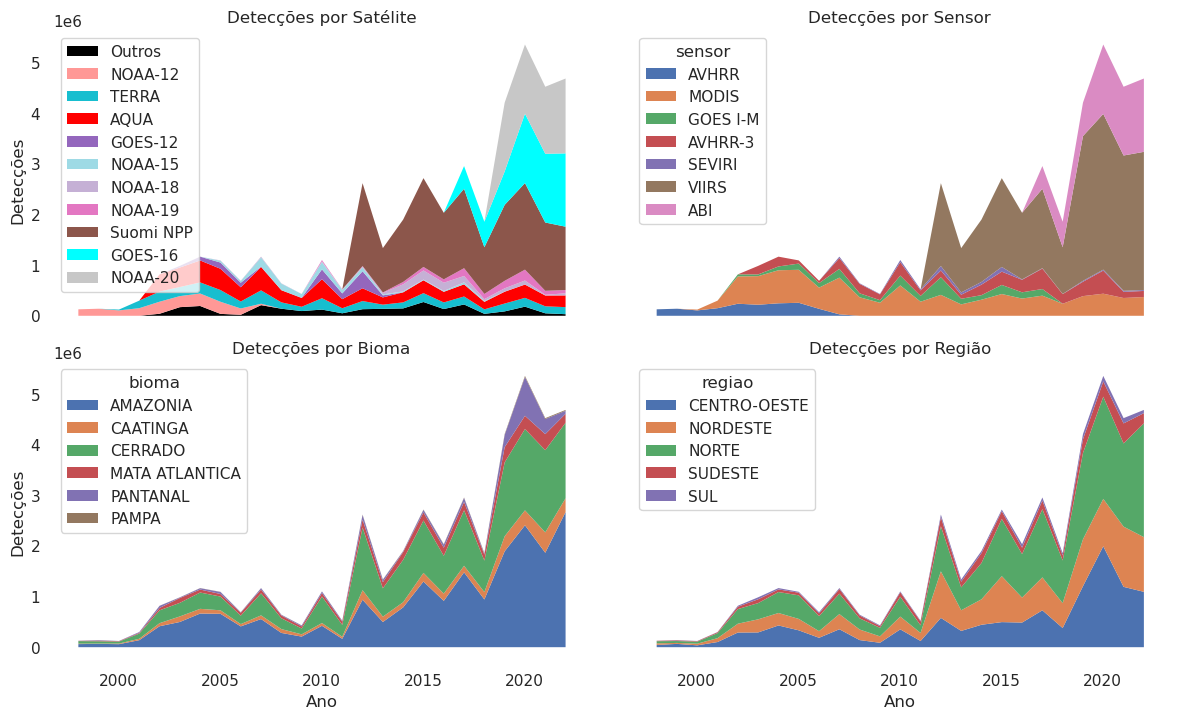

In [12]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 7))
fig.tight_layout()
axs = axs.flat

group_colums = [
    ('simp_satelite', 'Detecções por Satélite', 'Satélite'),
    ('sensor', 'Detecções por Sensor', 'Sensor'),
    ('bioma', 'Detecções por Bioma', 'Bioma'), 
    ('regiao', 'Detecções por Região', 'Região')
]

for index, (column, title, legend) in enumerate(group_colums):
    if column == 'simp_satelite':
        temp = df.groupby([df['datahora'].dt.year, df[column]])[column].count()
        sum_sat = temp.groupby('simp_satelite').sum()
        total = sum_sat.sum()
        threshold = 0.015
        sat_real = sum_sat.loc[lambda x: x/total >= threshold].index.values
        others = sum_sat.loc[lambda x: x/total < threshold].index.values
        unstack = temp.unstack()
        others_values: pd.Series = unstack[others].sum(axis=1)
        others_values.name = 'Outros'
        data_temp = pd.concat([others_values, unstack[sat_real]], axis=1)
    else:
        data_temp = df.groupby([df['datahora'].dt.year, df[column]])[column].count().unstack()
    data_temp.name = legend
    data_temp.plot(ax=axs[index], stacked=True, kind='area', linewidth=0,
                   color=satellites_colors if index == 0 else None, 
                   xlabel='Ano', ylabel='Detecções', title=title)
    ax.legend(title=legend)
    
fig.savefig(os.path.join(image_folder, 'medicoes_nos_anos.pdf'), bbox_inches="tight")